In [1]:
import keras
keras.__version__

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

In [42]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


%matplotlib inline

In [3]:
base_dir = "data/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [ ]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

In [ ]:
for root,dirs,files in os.walk(val_dir):
    print (root, len(files))

In [ ]:
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

In [4]:
class_folders = glob(train_dir + '/*')
num_classes = len(class_folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 2


In [5]:
os.listdir(train_dir)

['NORMAL', 'PNEUMONIA']

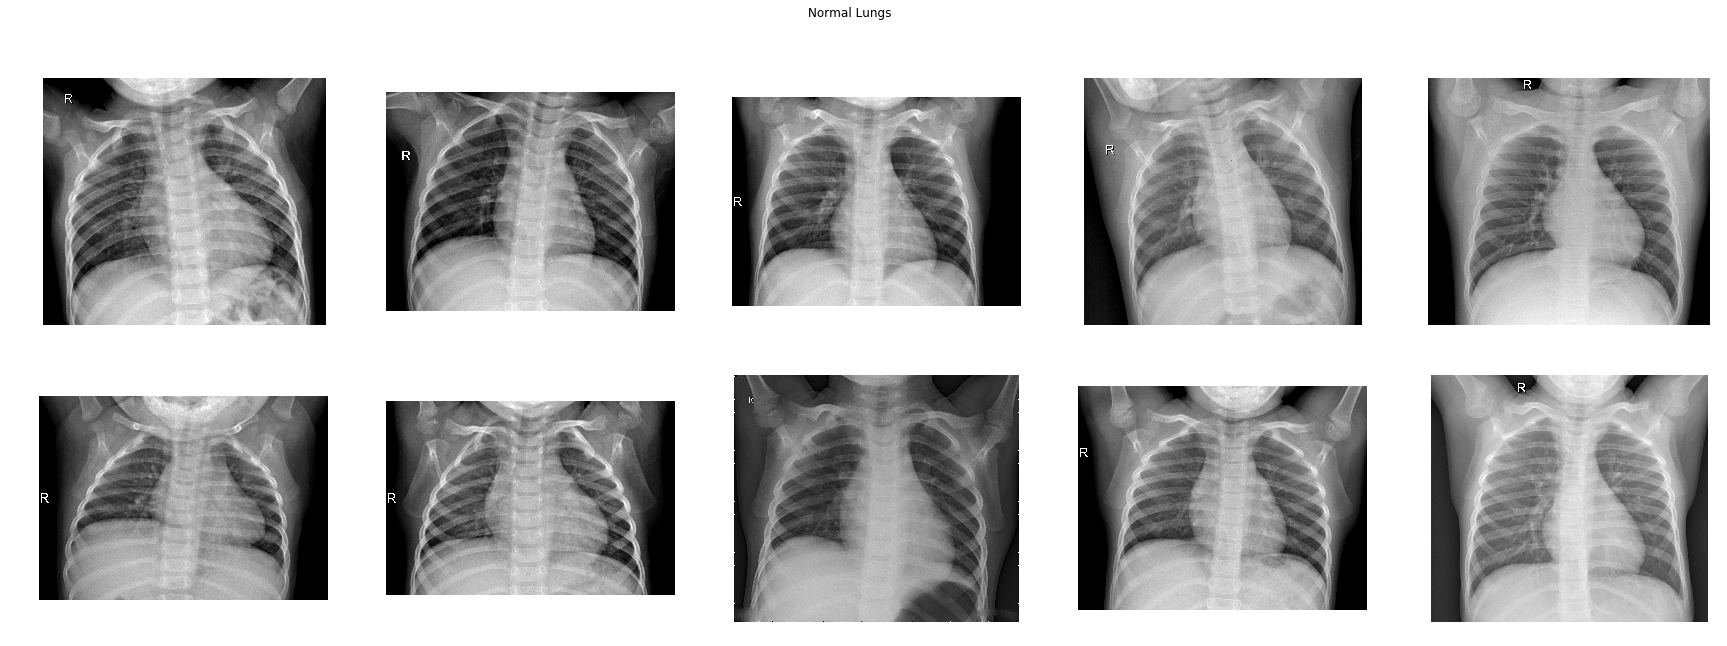

In [24]:
import random as rd
total_train_normal=os.listdir('data/chest_xray/train/NORMAL/')
total_train_pneumonia=os.listdir('data/chest_xray/train/PNEUMONIA/')


normal_xr=rd.sample(total_train_normal,10)
f,ax = plt.subplots(2,5, figsize=(30,10))
for i in range(0,10):
    img=cv2.imread('data/chest_xray/train/NORMAL/'+normal_xr[i])
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].axis('off')
f.suptitle('Normal Lungs')
plt.show()

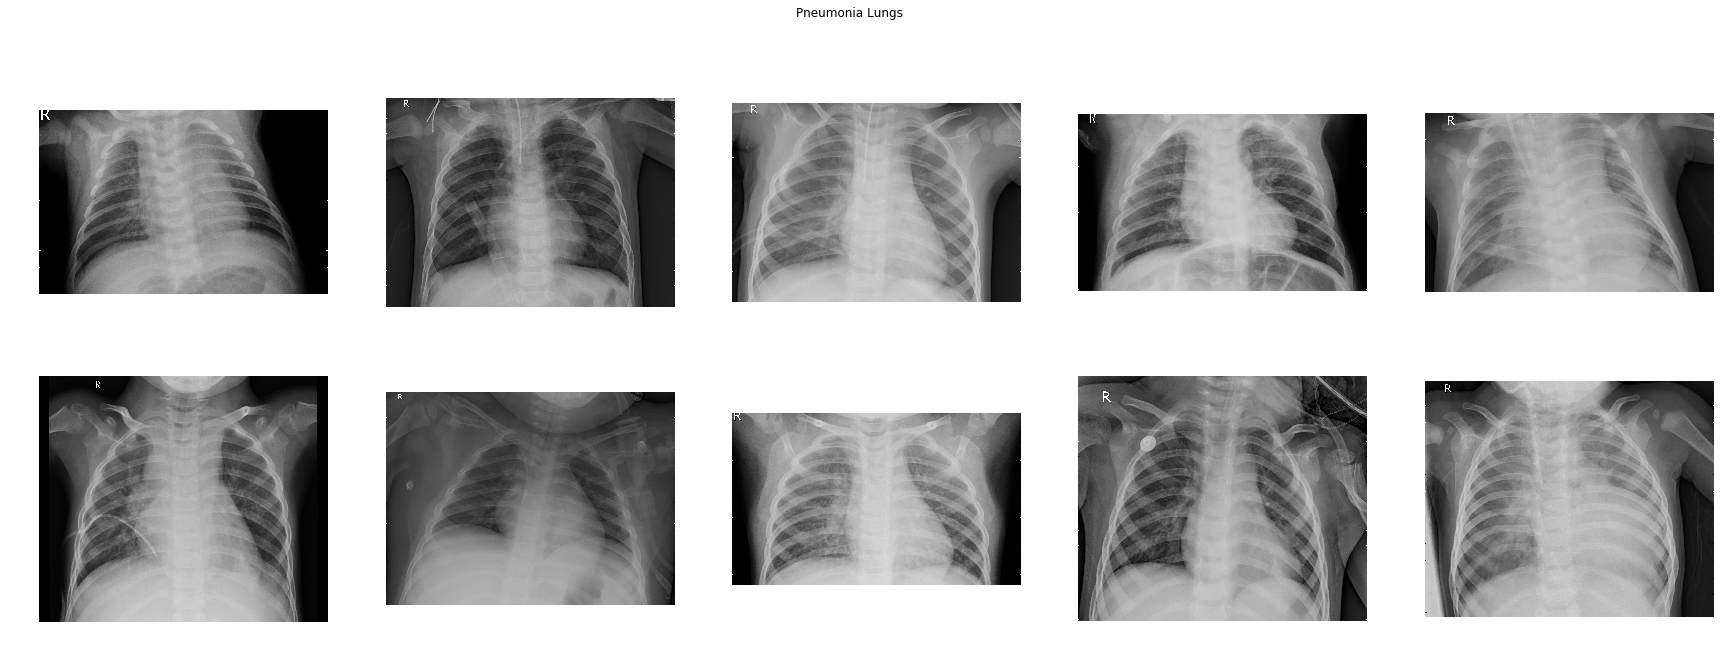

In [25]:
pneumonia_xr = rd.sample(total_train_pneumonia,10)
f,ax = plt.subplots(2,5, figsize=(30,10))

for i in range(0,10):
    img_2 = cv2.imread('data/chest_xray/train/PNEUMONIA/'+pneumonia_xr[i])
    ax[i//5,i%5].imshow(img_2)
    ax[i//5,i%5].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

In [32]:
img_normal = cv2.imread('data/chest_xray/train/NORMAL/IM-0117-0001.jpeg')
img_pneumonia = cv2.imread('data/chest_xray/train/PNEUMONIA/person7_bacteria_24.jpeg')

def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

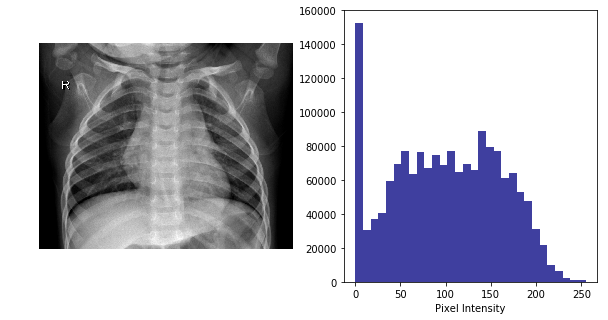

In [33]:
plotHistogram(img_normal)

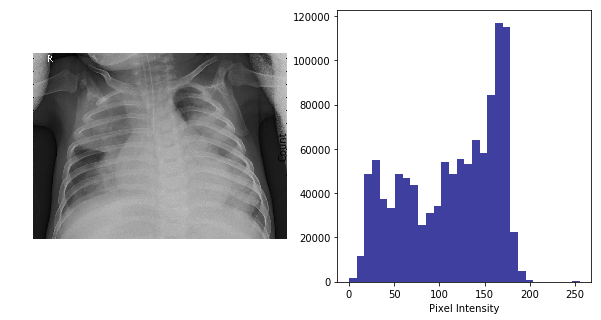

In [34]:
plotHistogram(img_pneumonia)

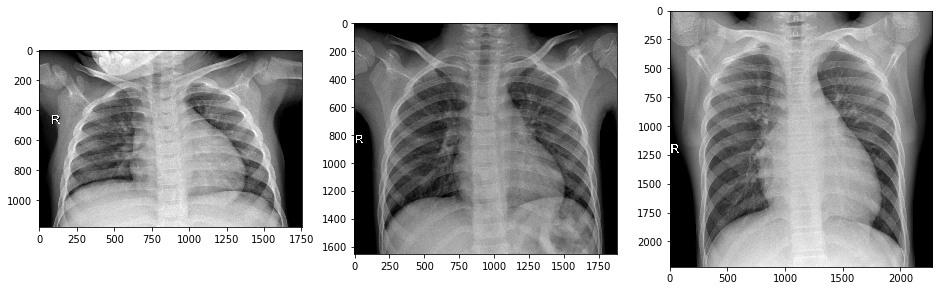

In [36]:
import random
multipleImages = glob('data/chest_xray/train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

No Pneumonia


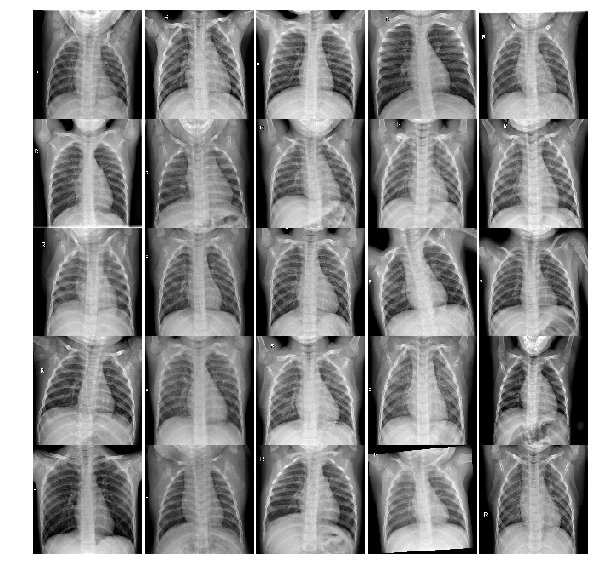

In [37]:
print("No Pneumonia")
multipleImages = glob('data/chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Yes Pneumonia


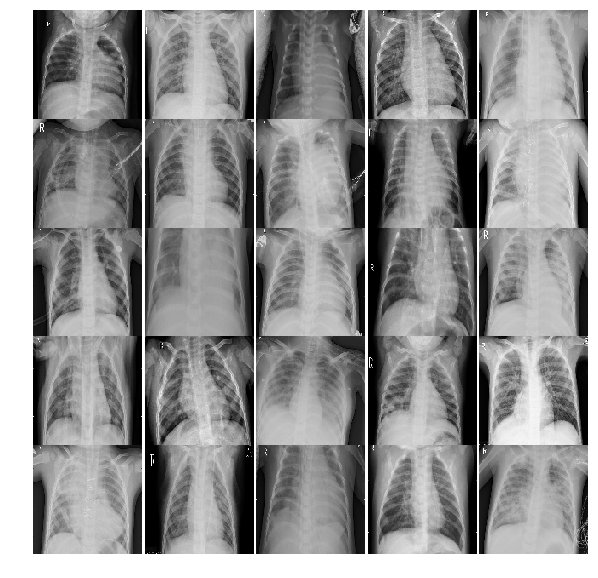

In [38]:
print("Yes Pneumonia")
multipleImages = glob('data/chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [40]:
Pimages = os.listdir("data/chest_xray/train/PNEUMONIA/")
Nimages = os.listdir("data/chest_xray/train/NORMAL/")

/home/sara/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(Left) - No Pneumonia Vs (Right) - Pneumonia
------------------------------------------------------------------------------------------


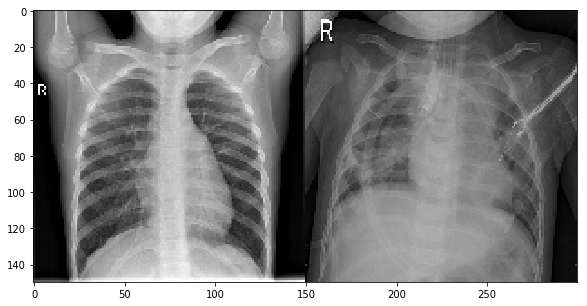

(Left) - No Pneumonia Vs (Right) - Pneumonia
------------------------------------------------------------------------------------------


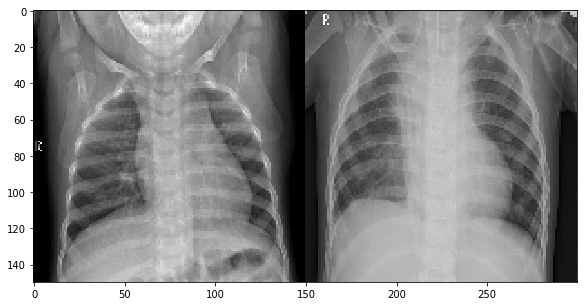

(Left) - No Pneumonia Vs (Right) - Pneumonia
------------------------------------------------------------------------------------------


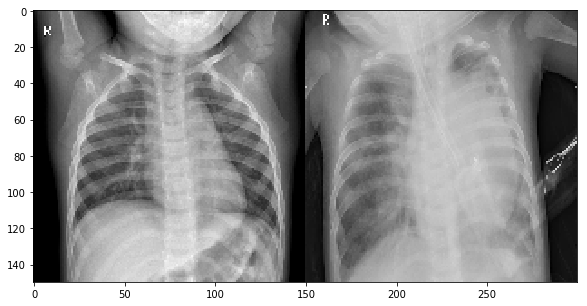

(Left) - No Pneumonia Vs (Right) - Pneumonia
------------------------------------------------------------------------------------------


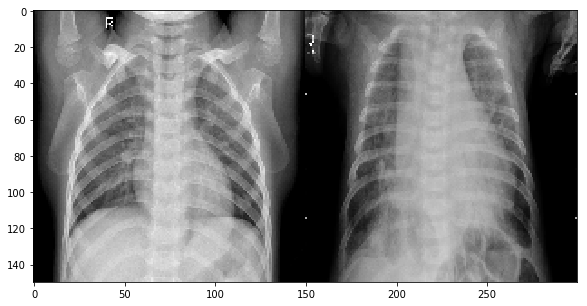

(Left) - No Pneumonia Vs (Right) - Pneumonia
------------------------------------------------------------------------------------------


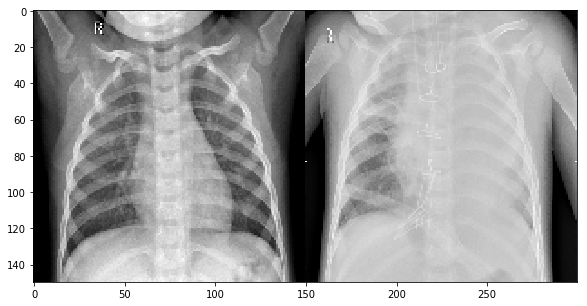

In [45]:
def plotter(i):
    imagep1 = cv2.imread("data/chest_xray/train/PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread("data/chest_xray/train/NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("------"*15)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

In [6]:
## Intilizing variables
output_classes = 2
learning_rate = 0.0001
img_width, img_height,channel = 64, 64, 3
# training_examples = 5216 
batch_size = 30 
epochs = 5
resume_model = False
xception_weights = 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [7]:
if resume_model == False:
    model = Sequential()
 
    model.add(Xception(weights = xception_weights , include_top=False,pooling = 'avg'))

    model.add(Dense(units=output_classes, activation='softmax'))

    model.layers[0].trainable = True

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=learning_rate),
                  metrics=['accuracy'])

  ## model.load_weights('xception_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

  ## Image generator function for training and validation
    img_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_img_generator = img_generator.flow_from_directory(
        train_dir,
        target_size = (img_width,img_height),
        batch_size = batch_size,
        class_mode = 'categorical')

    val_img_generator = img_generator.flow_from_directory(
                          val_dir,
                          target_size = (img_width,img_height),
                          class_mode = 'categorical')

    for i, layer in enumerate(model.layers):
        print('Layer: ',i+1,' Name: ', layer.name)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Layer:  1  Name:  xception
Layer:  2  Name:  dense_1


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


In [9]:
## Training only the newly added layer
if resume_model:
    model = load_model('chest_xray-Xception.h5')
else: 
    history = model.fit_generator(train_img_generator,
        steps_per_epoch=400,
        epochs = epochs,
        validation_data = val_img_generator,
        validation_steps=100)

Epoch 1/5
400/400 [==============================] - 803s 2s/step - loss: 0.1288 - acc: 0.9565 - val_loss: 1.0574 - val_acc: 0.5625
Epoch 2/5
400/400 [==============================] - 710s 2s/step - loss: 0.0224 - acc: 0.9922 - val_loss: 0.3822 - val_acc: 0.7500
Epoch 3/5
400/400 [==============================] - 708s 2s/step - loss: 0.0112 - acc: 0.9962 - val_loss: 0.5874 - val_acc: 0.7500
Epoch 4/5
400/400 [==============================] - 704s 2s/step - loss: 0.0129 - acc: 0.9963 - val_loss: 0.0680 - val_acc: 1.0000
Epoch 5/5
400/400 [==============================] - 703s 2s/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.5175 - val_acc: 0.8750


In [10]:
## saving model
model.save('chest_xray-Xception.h5')

In [53]:
score = model.evaluate_generator(val_img_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.5174706721305847
Test Accuracy:  0.875


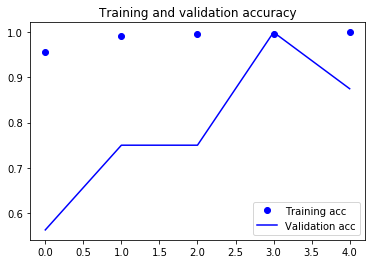

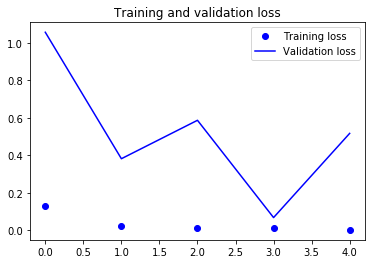

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

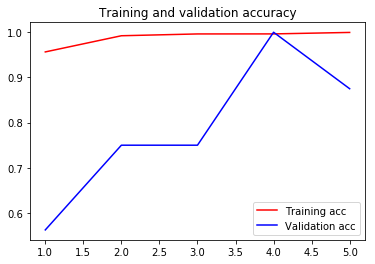

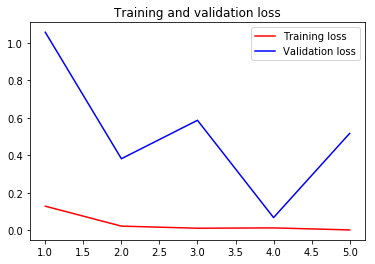

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

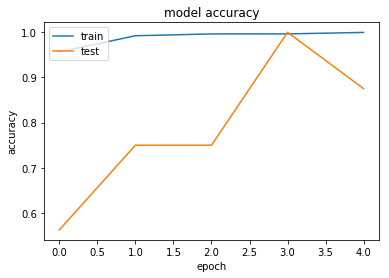

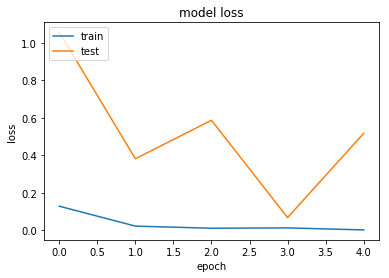

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()